In [1]:
import warnings
warnings.filterwarnings('ignore') # Reduce number of messages/warnings displayed

# HPO with dask-ml and cuml

## Introduction

&emsp; &emsp; &emsp; [Hyperparameter optimization](https://cloud.google.com/ai-platform/training/docs/hyperparameter-tuning-overview) is the task of picking the values for the hyperparameters of the model that provide the optimal results for the problem, as measured on a specific test dataset. This is often a crucial step and can help boost the model accuracy when done correctly. Cross-validation is often used to more accurately estimate the performance of the models in the search process. Cross-validation is the method of splitting the training set into complementary subsets and performing training on one of the subsets, then predicting the models performance on the other. This is a potential indication of how the model will generalise to data it has not seen before.

Despite its theoretical importance, HPO has been difficult to implement in practical applications because of the resources needed to run so many distinct training jobs.

The two approaches that we will be exploring in this notebook are :


#### 1. GridSearch

&emsp; &emsp; &emsp; As the name suggests, the "search" is done over each possible combination in a grid of parameters that the user provides. The user must manually define this grid.. For each parameter that needs to be tuned, a set of values are given and the final grid search is performed with tuple having one element from each set, thus resulting in a Catersian Product of the elements.

&emsp; &emsp; &emsp;For example, assume we want to perform HPO on XGBoost. For simplicity lets tune only `n_estimators` and `max_depth`

&emsp; &emsp; &emsp;`n_estimators: [50, 100, 150]`

&emsp; &emsp; &emsp;`max_depth: [6, 7, ,8]`
    
&emsp; &emsp; &emsp; The grid search will take place over |n_estimators| x |max_depth| which is 3 x 3 = 9. As you have probably guessed, the grid size grows rapidly as the number of parameters and their search space increases.

#### 2. RandomSearch


&emsp; &emsp; &emsp; [Random Search](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) replaces the exhaustive nature of the search from before with a random selection of parameters over the specified space. This method can outperform GridSearch in cases where the number of parameters affecting the model's performance is small (low-dimension optimization problems). Since this does not pick every tuple from the cartesian product, it tends to yield results faster, and the performance can be comparable to that of the Grid Search approach. It's worth keeping in mind that the random nature of this search means, the results with each run might differ.

Some of the other methods used for HPO include:

1. Bayesian Optimization

2. Gradient-based Optimization

3. Evolutionary Optimization

To learn more about HPO, some papers are linked to at the end of the notebook for further reading.

Now that we have a basic understanding of what HPO is, let's discuss what we wish to achieve with this demo. The aim of this notebook is to show the importance of hyper parameter optimisation and the performance of dask-ml GPU for xgboost and cuML-RF. 

For this demo, we will be using the [Airline dataset](http://kt.ijs.si/elena_ikonomovska/data.html). The aim of the problem is to predict the arrival delay. It has about 116 million entries with 13 attributes that are used to determine the delay for a given airline. We have modified this problem to serve as a binary classification problem to determine if the airline will be delayed (True) or not. 

Let's get started!

In [2]:
import numpy as np
import pandas as pd

import cudf
import xgboost as xgb

import dask_ml.model_selection as dcv
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster

from sklearn.metrics import make_scorer
from sklearn.utils import check_random_state


from cuml.ensemble import RandomForestClassifier
from cuml.model_selection import train_test_split
from cuml.metrics.accuracy import accuracy_score


import os
from urllib.request import urlretrieve
import gzip
import glob
from cuml.experimental.hyperopt_utils import plotting_utils

### Spinning up a CUDA Cluster

We start a local cluster and keep it ready for running distributed tasks with dask.


[LocalCUDACluster](https://github.com/rapidsai/dask-cuda) launches one Dask worker for each GPU in the current systems. It's developed as a part of the RAPIDS project.
Learn More:
- [Setting up Dask](https://docs.dask.org/en/latest/setup.html)
- [Dask Client](https://distributed.dask.org/en/latest/client.html)

In [3]:
cluster = LocalCUDACluster(dashboard_address="127.0.0.1:8005")
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8005/status,
Dashboard: http://127.0.0.1:8005/status,Workers: 2
Total threads: 2,Total memory: 187.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35849,Workers: 2
Dashboard: http://127.0.0.1:8005/status,Total threads: 2
Started: Just now,Total memory: 187.57 GiB
Comm: tcp://127.0.0.1:41901,Total threads: 1
Dashboard: http://127.0.0.1:34121/status,Memory: 93.78 GiB
Nanny: tcp://127.0.0.1:33599,


## Setup parameters  
NOTE: You must execute the download_data notebook before. It migth take up to 15 minutes 

In [4]:

num_rows = 2500000  # number of rows to be used in this notebook

# the parrent dir path is important to place the data and results in the correct flder
parent_dir = "/".join(os.getcwd().split("/")[:-1])

data_dir = os.path.join(parent_dir, "data", "airline-data")

orc_name = os.path.join(data_dir, "airline-data" + str(num_rows) + ".orc")

## Check the data is downloaded , otherwise execute the download_data.ipynb 

In [5]:
def prepare_dataset():
    try:
        if os.path.isfile(orc_name):
            df = cudf.read_orc(orc_name)
            df = df.drop("index",axis=1)
            return df
    except FileNotFoundError:
        print(f"Error: Archive '{orc_name}' not found")

In [6]:
df = prepare_dataset()

In [7]:
# Double check the precesence of Nan
for col in df.columns.to_list() :
    nan_vals = len ( df[df[col].isna()== True ])
    print (col , nan_vals)

ArrDelayBinary 0
YEAR 0
MONTH 0
DAY_OF_MONTH 0
DAY_OF_WEEK 0
CRS_DEP_TIME 0
CRS_ARR_TIME 0
OP_UNIQUE_CARRIER 0
OP_CARRIER_FL_NUM 0
ACTUAL_ELAPSED_TIME 0
ORIGIN 0
DEST 0
DISTANCE 0
DIVERTED 0


In [8]:
import time
from contextlib import contextmanager
# Helping time blocks of code
@contextmanager
def timed(txt):
    t0 = time.time()
    yield
    t1 = time.time()
    print("%32s time:  %8.5f" % (txt, t1 - t0))

In [9]:
# Define some default values to make use of across the notebook for a fair comparison
N_FOLDS = 5
N_ITER = 25
SEED = check_random_state(73)

In [10]:
label = 'ArrDelayBinary'

## Splitting Data

We split the data randomnly into train and test sets using the [cuml train_test_split](https://rapidsai.github.io/projects/cuml/en/0.12.0/api.html#cuml.preprocessing.model_selection.train_test_split) and create CPU versions of the data.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df, label,random_state=SEED,
                                                       test_size=0.2)

#### Get the data into the CPU 

In [12]:
X_cpu = X_train.to_pandas()
y_cpu = y_train.to_numpy()

X_test_cpu = X_test.to_pandas()
y_test_cpu = y_test.to_numpy()

## Setup Custom cuML scorers

The search functions (such as GridSearchCV) for scikit-learn and dask-ml expect the metric functions (such as accuracy_score) to match the “scorer” API. This can be achieved using the scikit-learn's [make_scorer](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) function.

We will generate a `cuml_scorer` with the cuML `accuracy_score` function.  You'll also notice an `accuracy_score_wrapper` which primarily converts the y label into a `float32` type. This is because some cuML models only accept this type for now and in order to make it compatible, we perform this conversion.

We also create helper functions for performing HPO in 2 different modes: 
1. `gpu-grid`: Perform GPU based GridSearchCV
2. `gpu-random`: Perform GPU based RandomizedSearchCV

In [13]:
def accuracy_score_wrapper(y, y_hat): 
    """
        A wrapper function to convert labels to float32, 
        and pass it to accuracy_score.
        
        Params:
        - y: The y labels that need to be converted
        - y_hat: The predictions made by the model
    """
    y = y.astype("float32") # cuML RandomForest needs the y labels to be float32
    return accuracy_score(y, y_hat, convert_dtype=True)

accuracy_wrapper_scorer = make_scorer(accuracy_score_wrapper)
cuml_accuracy_scorer = make_scorer(accuracy_score, convert_dtype=True)

#### This creates a wrapper to help us select the details of the HPO we want to compare and run

In [14]:
def do_HPO(model, gridsearch_params, scorer, X, y, mode='gpu-Grid', n_iter=10):
    """
        Perform HPO based on the mode specified
        
        mode: default gpu-Grid. The possible options are:
        1. gpu-grid: Perform GPU based GridSearchCV
        2. gpu-random: Perform GPU based RandomizedSearchCV
        
        n_iter: specified with Random option for number of parameter settings sampled
        
        Returns the best estimator and the results of the search
    """
    if mode == 'gpu-grid':
        print("gpu-grid selected")
        clf = dcv.GridSearchCV(model,
                               gridsearch_params,
                               cv=N_FOLDS,
                               scoring=scorer)
    elif mode == 'gpu-random':
        print("gpu-random selected")
        clf = dcv.RandomizedSearchCV(model,
                               gridsearch_params,
                               cv=N_FOLDS,
                               scoring=scorer,
                               n_iter=n_iter)

    else:
        print("Unknown Option, please choose one of [gpu-grid, gpu-random]")
        return None, None
    res = clf.fit(X, y)
    print("Best clf and score {} {}\n---\n".format(res.best_estimator_, res.best_score_))
    return res.best_estimator_, res

In [15]:
def print_acc(model, X_train, y_train, X_test, y_test, mode_str="Default"):
    """
        Trains a model on the train data provided, and prints the accuracy of the trained model.
        mode_str: User specifies what model it is to print the value
    """
    y_pred = model.fit(X_train, y_train).predict(X_test)
    score = accuracy_score(y_pred, y_test.astype('float32'), convert_dtype=True)
    print("{} model accuracy: {}".format(mode_str, score))

#### Look at trainin set shape, we are going to read 200k rows and 13 columns as features 

In [16]:
X_train.shape

Index(['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME',
       'CRS_ARR_TIME', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_FL_NUM',
       'ACTUAL_ELAPSED_TIME', 'ORIGIN', 'DEST', 'DISTANCE', 'DIVERTED'],
      dtype='object')

## Launch HPO

We will first see the model's performances without the gridsearch and then compare it with the performance after searching.

### XGBoost

To perform the Hyperparameter Optimization, we make use of the sklearn version of the [XGBClassifier](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn).We're making use of this version to make it compatible and easily comparable to the scikit-learn version. The model takes a set of parameters that can be found in the documentation. We're primarily interested in the `max_depth`, `learning_rate`, `min_child_weight`, `reg_alpha` and `num_round` as these affect the performance of XGBoost the most.

Read more about what these parameters are useful for [here](https://xgboost.readthedocs.io/en/latest/parameter.html)

#### Default Performance

We first use the model with it's default parameters and see the accuracy of the model. In this case, it is 84%

In [17]:
model_gpu_xgb_ = xgb.XGBClassifier(tree_method='gpu_hist',random_state=SEED)

In [18]:
# ## Random Forest
# model_rf_ = RandomForestClassifier()

# print("Default acc: ",accuracy_score(model_rf_.fit(X_train, y_train).predict(X_test), y_test))

#### Lets define a set of parameters to explore with model of interest

In [19]:
# # For rf_model
# model_rf = RandomForestClassifier()

# # range
# params_rf = {
#     "max_depth": np.arange(start=3, stop = 15, step = 2), # Default = 6
#     "max_features": [0.1, 0.50, 0.75, 'auto'], #default = 0.3
#     "n_estimators": [100, 200, 1000]
#             }


#### Parameter Distributions

The way we define the grid to perform the search is by including ranges of parameters that need to be used for the search. In this example we make use of [np.arange](https://docs.scipy.org/doc/numpy/reference/generated/numpy.arange.html) which returns an ndarray of even spaced values, [np.logspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.logspace.html#numpy.logspace) returns a specified number of ssamples that are equally spaced on the log scale. We can also specify as lists, NumPy arrays or make use of any random variate sample that gives a sample when called. SciPy provides various functions for this too.

In [20]:
# For xgb_model
model_gpu_xgb = xgb.XGBClassifier(tree_method='gpu_hist',random_state=SEED)

# More range 
params_xgb = {
    "max_depth": np.arange(start=3, stop = 12, step = 3), # Default = 6
    "alpha" : np.logspace(-3, -1, 5), # default = 0
    "learning_rate": [0.05, 0.1, 0.15], #default = 0.3
    "min_child_weight" : np.arange(start=2, stop=10, step=3), # default = 1
    "n_estimators": [100, 200, 1000]
}

#### RandomizedSearchCV

We'll now try [RandomizedSearchCV](https://dask-ml.readthedocs.io/en/latest/modules/generated/dask_ml.model_selection.RandomizedSearchCV.html).
`n_iter` specifies the number of parameters points theat the search needs to perform. Here we will search `N_ITER` (defined earlier) points for the best performance.

In [21]:
mode = "gpu-random"

with timed("XGB-"+mode):
    res, results = do_HPO(model_gpu_xgb,
                                   params_xgb,
                                   cuml_accuracy_scorer,
                                   X_train,
                                   y_cpu,
                                   mode=mode,
                                   n_iter=N_ITER)
print("Searched over {} parameters".format(len(results.cv_results_['mean_test_score'])))

gpu-random selected
Best clf and score XGBClassifier(alpha=0.001, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...) 0.8646834969520569
---

                  XGB-gpu-random time:  145.61647
Searched over 25 parameters


In [22]:
print_acc(model_gpu_xgb_, X_train, y_cpu, X_test, y_test_cpu)
print_acc(res, X_train, y_cpu, X_test, y_test_cpu, mode_str=mode)

Default model accuracy: 0.8487619757652283
gpu-random model accuracy: 0.86599200963974


#### XgBoost improves 
With a very small set of parameter and with a random search we have a 0.863 accuracy vs 0.848 baseline accuracy a gain of 1% in about 2 minutes of testing, not bad. The main target for HPO is to explore wider ranges of parameters and usually with more data.

In [23]:
# mode = "gpu-random"

# with timed("RF-"+mode):
#     res, results = do_HPO(model_rf,
#                           params_rf,
#                           cuml_accuracy_scorer,
#                           X_train.to_cupy().get(),
#                           y_cpu,
#                           mode=mode,
#                          n_iter = N_ITER)
# print("Searched over {} parameters".format(len(results.cv_results_['mean_test_score'])))

In [24]:
# print("Improved acc: ",accuracy_score(res.predict(X_test), y_test))

#### Heatmaps 
   - Between parameter pairs (we can do a combination of all possible pairs, but only one are shown in this notebook) 
   - This gives a visual representation of how the pair affect the test score

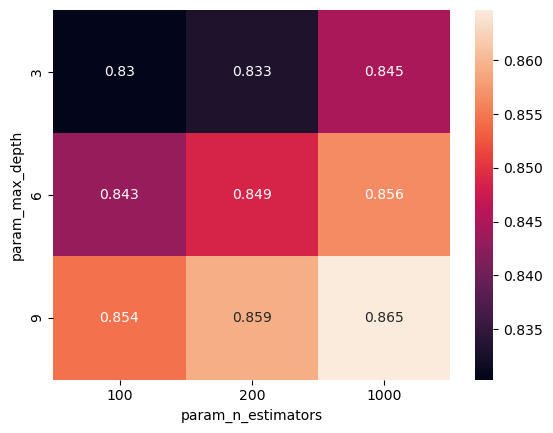

In [25]:
df_randomsearch = pd.DataFrame(results.cv_results_)
plotting_utils.plot_heatmap(df_randomsearch, "param_max_depth", "param_n_estimators")

### Now lets perfrom the Grid-search strategy. This will explore all the the possible combinations , we should skip this for the sake of time (takes about 1 hrs)

In [26]:
mode = "gpu-grid"

# For xgb_model
model_gpu_xgb = xgb.XGBClassifier(tree_method='gpu_hist',random_state=SEED)

with timed("XGB-"+mode):
    res, results = do_HPO(model_gpu_xgb,
                            params_xgb,
                                   cuml_accuracy_scorer,
                                   X_train,
                                   y_cpu,
                                   mode=mode)
print("Searched over {} parameters".format(len(results.cv_results_['mean_test_score'])))

gpu-grid selected
Best clf and score XGBClassifier(alpha=0.0031622776601683794, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...) 0.8654214978218079
---

                    XGB-gpu-grid time:  2521.08283
Searched over 405 parameters


In [27]:
# mode = "gpu-grid"

# # For rf_model
# model_rf = RandomForestClassifier()

# with timed("RF-"+mode):
#     res, results = do_HPO(model_rf,
#                           params_rf,
#                           cuml_accuracy_scorer,
#                           X_train.to_cupy().get(),
#                           y_cpu,
#                           mode=mode,
#                          n_iter = N_ITER)
# print("Searched over {} parameters".format(len(results.cv_results_['mean_test_score'])))

In [28]:
print_acc(model_gpu_xgb_, X_train, y_cpu, X_test, y_test_cpu)
print_acc(res, X_train, y_cpu, X_test, y_test_cpu, mode_str=mode)

Default model accuracy: 0.8487619757652283
gpu-grid model accuracy: 0.8669400215148926


#### We have run the classifiers with two strategies its up to you decide which one is the best 
* **Xgboost baseline accuracy is 0.848**
* **Xgboost with Random search is 0.869 accuracy -> 5 minutes**
* **Xgboost with Grid search is 0.866 accuracy  -> 1 hour**

#### Mean/Std of test scores

We fix all parameters except one for each of these graphs and plot the effect the parameter has on the mean test score with the error bar indicating the standard deviation

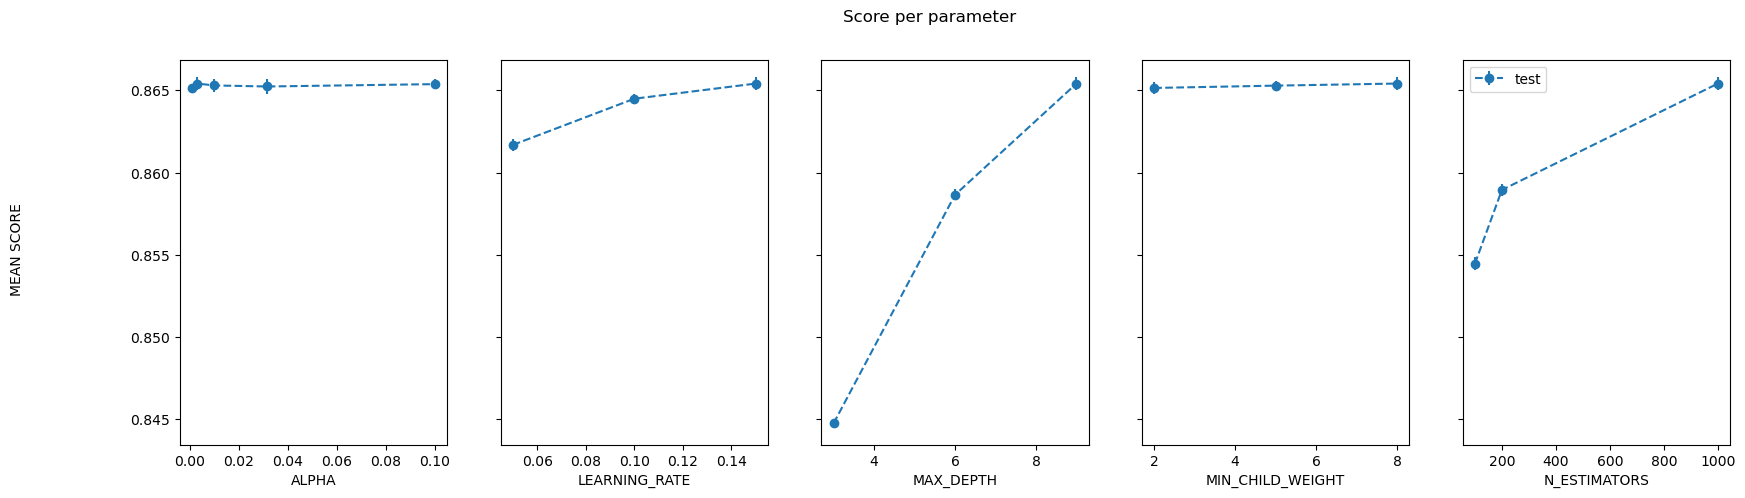

In [29]:
plotting_utils.plot_search_results(results)

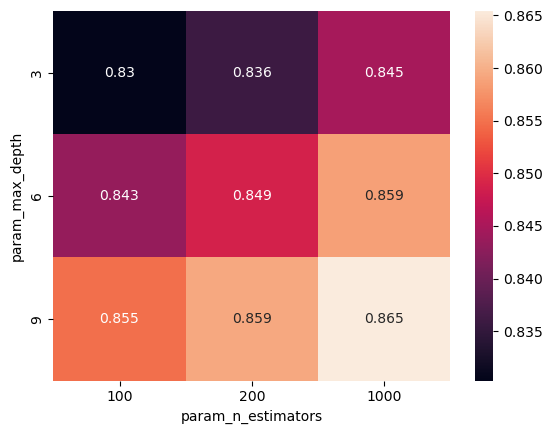

In [30]:
df_gridsearch = pd.DataFrame(results.cv_results_)
plotting_utils.plot_heatmap(df_gridsearch, "param_max_depth", "param_n_estimators")

## Conclusion and Next Steps

We notice improvements in the performance for a really basic version of the GridSearch and RandomizedSearch. Generally, the more data we use, the better the model performs, so you are encouraged to try for larger data and broader range of parameters.

This experiment can also be repeated with different classifiers and different ranges of parameters to notice how HPO can help improve the performance metric. In this example, we have chosen a basic metric - accuracy, but you can use more interesting metrics that help in determining the usefulness of a model. You can even send a list of parameters to the scoring function. This makes HPO really powerful, and it can add a significant boost to the model that we generate.


#### Further Reading

- [The 5 Classification Evaluation Metrics You Must Know](https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226)
- [11 Important Model Evaluation Metrics for Machine Learning Everyone should know](https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/)
- [Algorithms for Hyper-Parameter Optimisation](http://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)
- [Forward and Reverse Gradient-Based Hyperparameter Optimization](http://proceedings.mlr.press/v70/franceschi17a/franceschi17a-supp.pdf)
- [Practical Bayesian Optimization of Machine
Learning Algorithms](http://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf)
- [Random Search for Hyper-Parameter Optimization](http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf)

In [31]:
# close the client , it realease memory and clean the work space
client.close()